In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util

2023-07-13 14:38:43.571646: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 14:38:43.607090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 14:38:43.607946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 14:38:44.382011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Production Planning

## Production Planning

**Let's consider this (simplified) decision problem**

<center><img src="assets/job_selection.jpg" width=60%></center>

* We need to select from a _set production jobs_
* Performing a job provides a value
* We have a minimum value that we need reach
* Every job has an associated _cost_

## Problem Formulation

**We provide a mathematical formulation for this problem**

$$\begin{align}
z^* = \text{argmin}_{z}\ & \sum_{j=1}^n y_j z_j \\
\text{subject to: } & \sum_{j=1}^n v_j z_j \geq v_{min} \\
& z_j \in \{0, 1\} & \forall j = 1..n
\end{align}$$

Where:

* $z = 1$ iff we pick the $j$-th job, and 0 otherwise
* $v_j$ is the value for the $j$-th job
* $v_{min}$ is the minimum required value
* $y_j$ is the cost for the $j$-th job

## Solution Approaches

**Optimization problems can be address via several approaches**

Some come from th AI fields, other from Mathematics

* Mathematical Programming (e.g. MILP)
* Constraint Programming
* SAT Modulo Theories
* ...

**Problems in this class can be very challenging**

...But mature tools to address them exist, e.g.:

* The [Gurobi]() solver
* Google [or-tools]()
* The [Z3]() theorem prover by Microsoft
* ...

## Uncertainty

**In some real world scenarios the costs would be unknown**

...Typically, beucase they are _subject to uncertainty_

* In other words, we know how much we gain
* ...But we don't know how much we pay

**We will assume that at least _some_ information is available**

* In particular that $y$ is _not observable_
* ...But also correlated with _some quantity $x$_ that we can observe

E.g. some kind of economic indicator

**We will also assume that we have historical data**

* In particular, by keeping track of what happened in the past
* We collected some examples $(x_i, y_i)$

## Adjusted Formulation and Solution Strategy

**How does this change our formulation?**

Under uncertainty, we'll want to maximize the _expected_ profit:

$$\begin{align}
z^* = \text{argmin}_{z}\ & \sum_{j=1}^n \mathbb{E}_{y \sim P(Y)} [y_j]\, z_j \\
\text{subject to: } & \sum_{j=1}^n v_j z_j \geq v_{min} \\
& z_j \in \{0, 1\} & \forall j = 1..n
\end{align}$$

* The notation $\mathbb{E}$ represents an expectation
* I.e. a mean over all possible outcomes
* Basically, we want to do well on average

**More risk-averse formulations are possible, but we'll not cover them**

## Predict, the Optimize

**A possible solution strategy consists in:**

* Based on $x$, obtaining an estimate for the expected costs
* ...Then we can solve the decision problem as before

**This strategy is known as _"predict, then optimize"_**

* We can use Machine Learning to train an estimator
* With the estimator, we can predict the expected costs
* ...Then we can use optimization to find the best decisions

**We can view the estimation as a regression problem**

...And this is a sound strategy

* In fact, under the right conditions
* A regressor actually tries to estimate a _mean_

## Data Generation

**We will use synthetic data for this use case**

First, we generate the know parameters for the knapsack problem

In [2]:
nitems, rel_req, seed = 20, 0.5, 42
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)
display(prb)

ProductionProblem(values=[1.14981605 1.38028572 1.29279758 1.23946339 1.06240746 1.06239781
 1.02323344 1.34647046 1.240446   1.28322903 1.0082338  1.38796394
 1.33297706 1.08493564 1.07272999 1.0733618  1.1216969  1.20990257
 1.17277801 1.11649166], requirement=11.830809153591138)

* The jobs
* The values
* The minimum requirement on the total value

## Data Generation

**The we generate a collection of historical data**

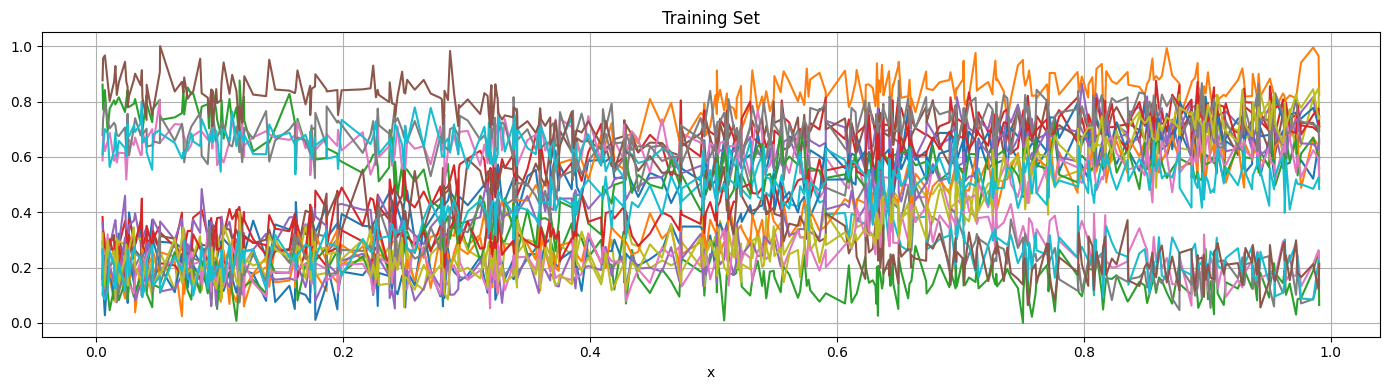

In [3]:
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=.2, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=False)

* On the $x$ axis we have the market indicator
* Every color corresponds to the cost for a different investment option

## Data Generation

**We also generate a second collection of data for testing**

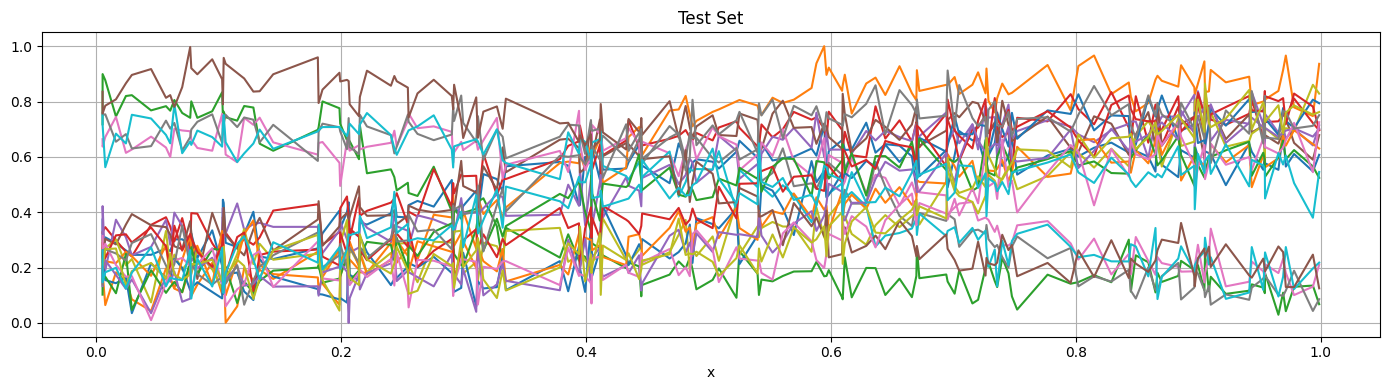

In [4]:
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0.2, noise_type='normal', noise_scale_type='absolute', nsamples_per_point=1)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=False)

* We will not use this data for training
* So we can use to assess the performance on unseen examples

## Training the Estimator

**We can not train our estimator**

CPU times: user 9.19 s, sys: 339 ms, total: 9.53 s
Wall time: 7.13 s


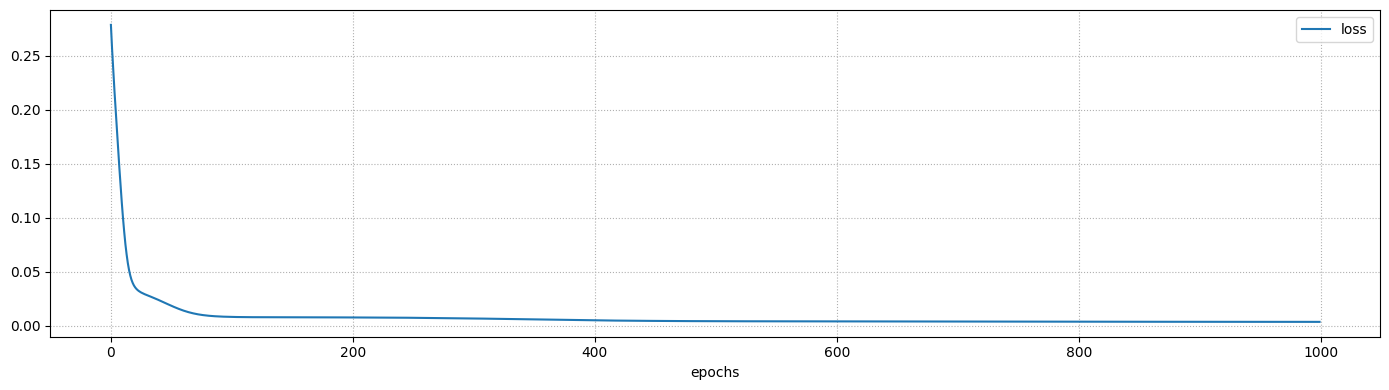

R2: 0.90, MAE: 0.049, RMSE: 0.06 (training)
R2: 0.90, MAE: 0.05, RMSE: 0.06 (test)


In [5]:
pfl_1s = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[16], name='pfl_1s', output_activation='linear')
%time history = util.train_nn_model(pfl_1s, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0)
util.plot_training_history(history, figsize=figsize, print_final_scores=False)
util.print_ml_metrics(pfl_1s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_1s, data_ts.index.values, data_ts.values, label='test')

## Estimation Accuracy

**Our estimator is quite accurate, despite the presence of uncertainty**

R2: 0.83
MAE: 0.04


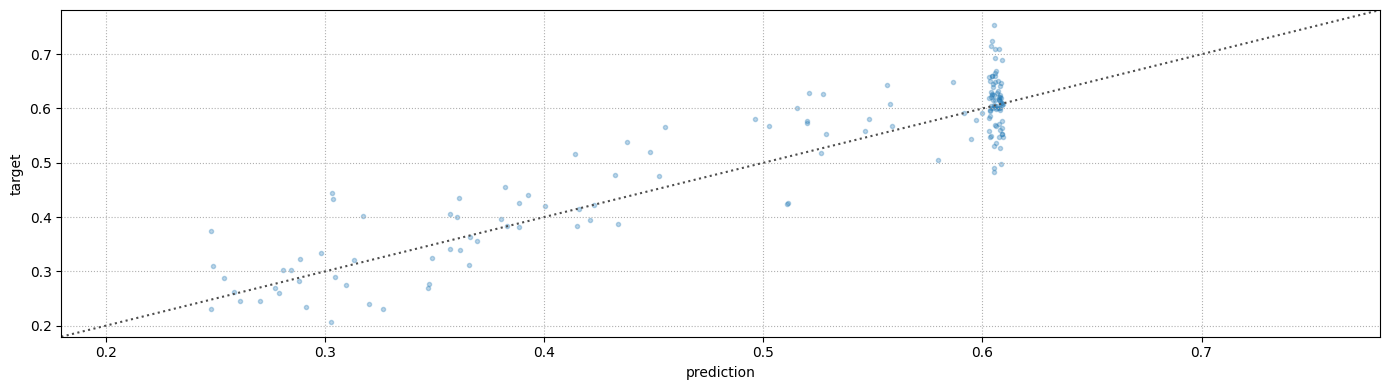

In [6]:
pfl_1s_pred_ts = pfl_1s.predict(data_ts.index.values, verbose=0)
util.plot_pred_scatter(data_ts.values[:, 0], pfl_1s_pred_ts[:, 0], figsize=figsize, alpha=0.3)

* Here we see the prediction/ground truth correlation for the 1st item

## Evaluating the Decisions

**Our final evaluation, however, should be in terms of _cost_**

We can do it like this:

* Let $z^*(\hat{y})$ be the solution we compute based on the cost estimates $\hat{y}$
* Let $z^*(y)$ be the solution we compute based on the true costs $y$
* Then, we can measure how well we are doing by computing:

$$
\frac{\text{cost}(z^*(\hat{y})) - \text{cost}(z^*(y))}{\text{cost}(z^*(y))}
$$

**This is called _relative (post-hoc) regret_**

* It's the different between the cost that we actually payed
* ...And the cost we could have paid with the benefit of hindsight

## Post-hoc Regret Evaluation

**Let's check how well we're doing in terms of post-hoc regret**

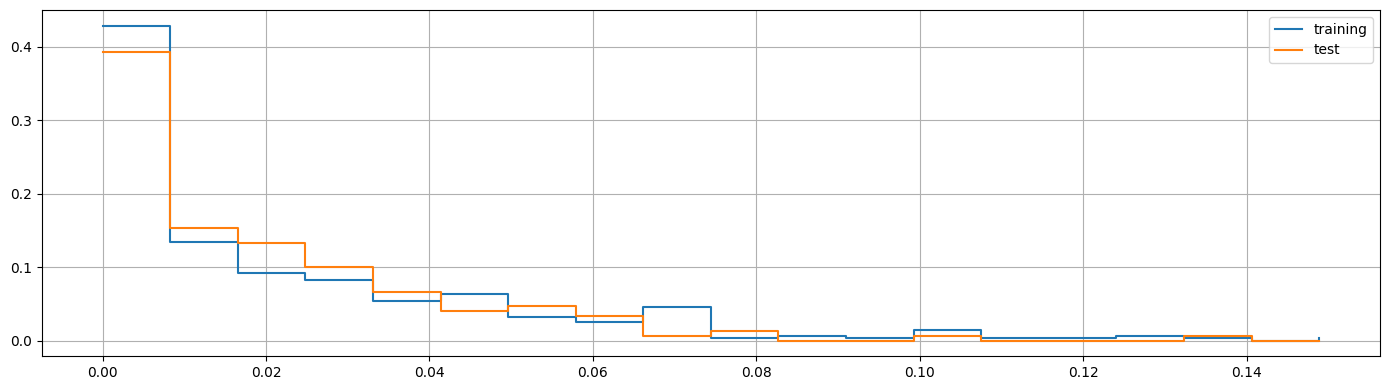

Mean: 0.023 (training), 0.020 (test)


In [7]:
r_tr_1s = util.compute_regret(prb, pfl_1s, data_tr.index.values, data_tr.values)
r_ts_1s = util.compute_regret(prb, pfl_1s, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr_1s, figsize=figsize, label='training', data2=r_ts_1s, label2='test', print_mean=True)

The average is roughly ~2%

## Limits of this Approach

**The "predict, then optimize" approach work well on one condition**

Our ML model should _effective at estimating the expected costs_

* However, this is not always possible
* Sometimes you lack clear statistical information on the data
* ...Or sometimes you are forced to use a simpler model
* ...For example to provide explainability

**We will run an experiment to test this condition**

We will restrict ourselves to using a Linear Regressor

* As an ML model, this is _much_ easier to interpret
* ...But also considerably less accurate in many cases

## Training a Linear Regressor

**Let's try our new, simpler, model**

CPU times: user 8.08 s, sys: 278 ms, total: 8.35 s
Wall time: 6.71 s


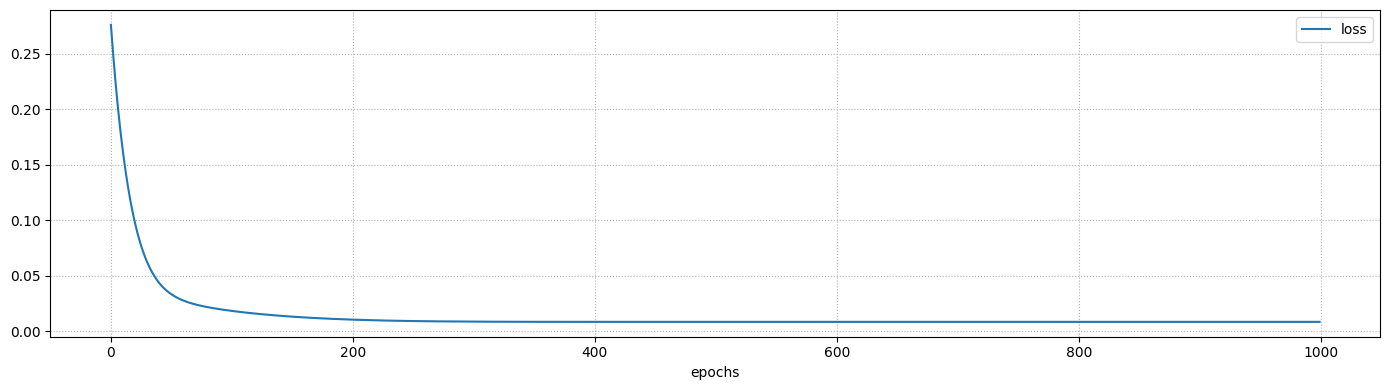

R2: 0.79, MAE: 0.074, RMSE: 0.09 (training)
R2: 0.78, MAE: 0.076, RMSE: 0.09 (test)


In [8]:
pfl_1s_l = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='pfl_1s_l', output_activation='linear')
%time history = util.train_nn_model(pfl_1s_l, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0)
util.plot_training_history(history, figsize=figsize, print_final_scores=False)
util.print_ml_metrics(pfl_1s_l, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_1s_l, data_ts.index.values, data_ts.values, label='test')

## Regret Evaluation

**Let's check how the model fares in terms of (post-hoc) regret**

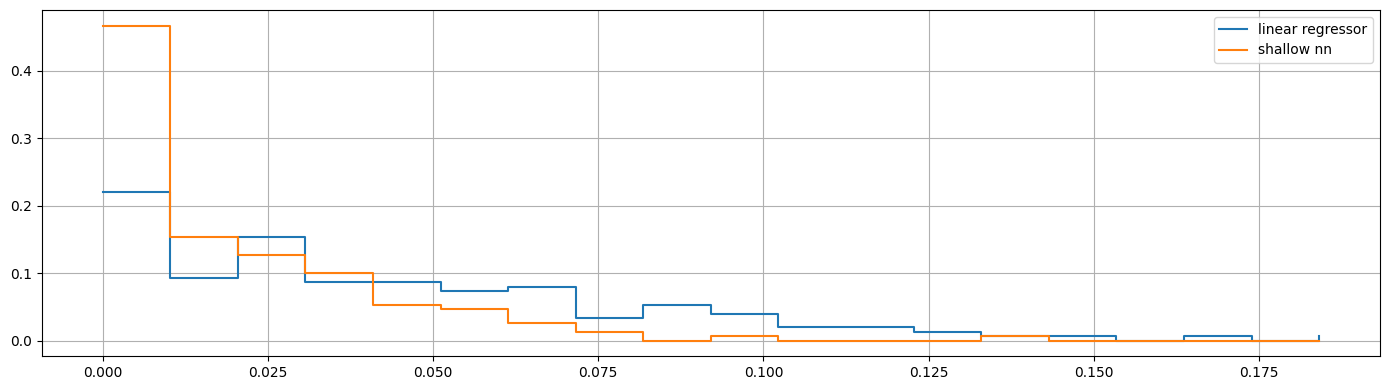

Mean: 0.044 (linear regressor), 0.020 (shallow nn)


In [9]:
r_tr_1s_l = util.compute_regret(prb, pfl_1s_l, data_tr.index.values, data_tr.values)
r_ts_1s_l = util.compute_regret(prb, pfl_1s_l, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_1s_l, figsize=figsize, label='linear regressor', data2=r_ts_1s, label2='shallow nn', print_mean=True)

* The simpler model leads to twice the regret

## A Hybrid Method

**In this kind of situation, using a hybrid method can close the gap**

A hybrid method is one that meld elements to different fields

* We are already using learning and optimization in sequence
* ...But hybrid methods do it _at the same time_

**The method we will use is called _Decision Focused Learning_**

...And consists in minimizing regret at training time:

* Given the current network parameters $\theta$
* We solve one optimization problem for every training example
* We identify an improvement direction for the parameters
* ...And we adjust the parameters in that direction

## Training a DFL Approach

**Let's train a DFL approach**

CPU times: user 2min 48s, sys: 11min 9s, total: 13min 57s
Wall time: 1min 23s


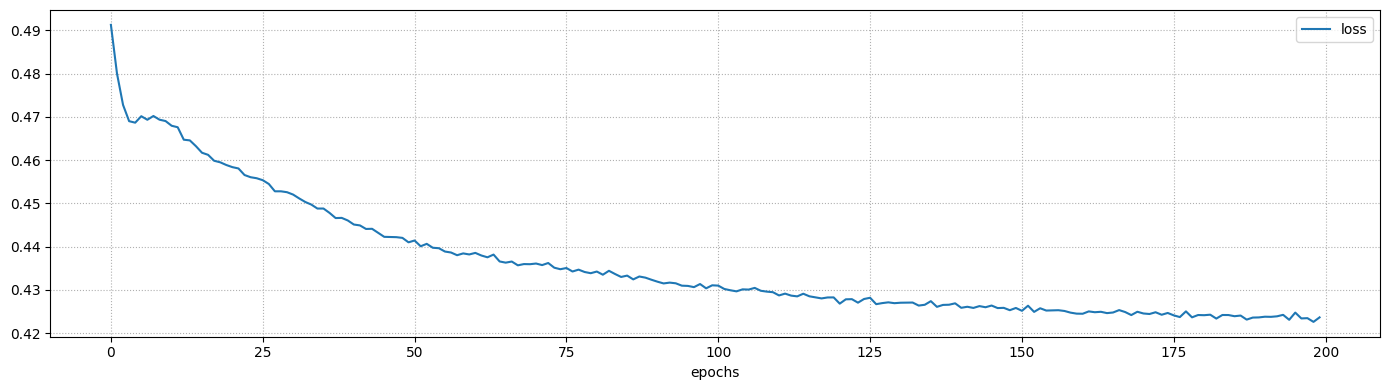

R2: 0.66, MAE: 0.089, RMSE: 0.12 (training)
R2: 0.67, MAE: 0.089, RMSE: 0.12 (test)


In [10]:
spo_1s = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='spo_1s', output_activation='linear', loss_type='spo', recompute_chance=0.05)
%time history = util.train_dfl_model(spo_1s, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, warm_start_pfl=pfl_1s_l)
util.plot_training_history(history, figsize=figsize, print_final_scores=False)
util.print_ml_metrics(spo_1s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo_1s, data_ts.index.values, data_ts.values, label='test')

## Estimation Accuracy

**In terms of prediction quality, DFL approaches are _considerably worse_**

R2: 0.54
MAE: 0.08


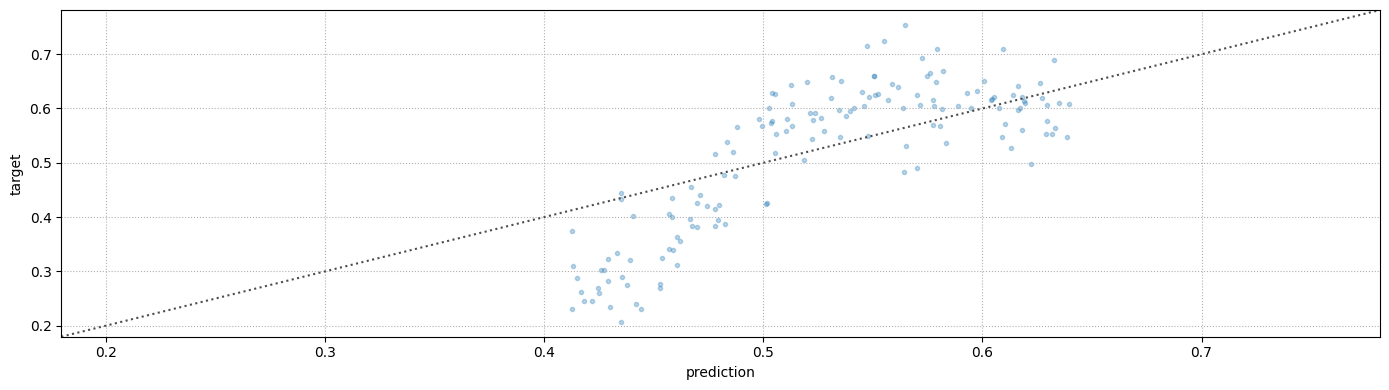

In [12]:
spo_1s_pred_ts = spo_1s.predict(data_ts.index.values, verbose=0)
util.plot_pred_scatter(data_ts.values[:, 0], spo_1s_pred_ts[:, 0], figsize=figsize, alpha=0.3)

...Since their goal is not accuracy, but cost minimization

## Regret Evaluation

**We get a main advantage in terms of regret** 

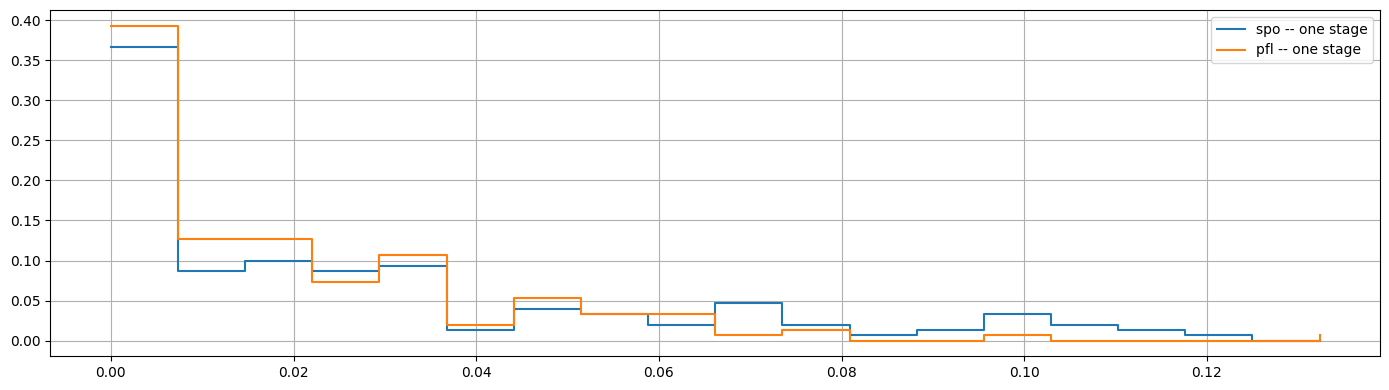

Mean: 0.028 (spo -- one stage), 0.020 (pfl -- one stage)


In [11]:
r_ts_spo_1s = util.compute_regret(prb, spo_1s, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo_1s, figsize=figsize, label='spo -- one stage', data2=r_ts_1s, label2='pfl -- one stage', print_mean=True)

Despite the model simplicity, we are almost matching our original results

## Final Consideration